# Molecular Data Analysis 

In this notebook, I focus on classifying the unknown epithelial cells as malignant or normal. The main questions are:

- Which genes characterize the Unknown cells?
- Are the Unknown cells more similar to Malignant or Normal cells?
- Does scaling affect the GMM results?

## Library Imports

In this step, I load the libraries required for data preprocessing and analysis.

In [2]:
# Core data handling
import os
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Scientific / ML
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture

# Specialized bioinformatics / spatial data
import scanpy as sc
import spatialdata as sd

# --- Create the folder if it doesn't exist ---
os.makedirs("figures", exist_ok=True)

## Dataset Loading

In this section, the datasets used for the analysis are loaded:

- **Xenium_V1_FFPE_Human_Breast_IDC.zarr** (referred to as *xenium*): the full spatial transcriptomics dataset.  
- **epithelial_cells**: a subset of *xenium* containing only epithelial cells, on which the downstream analyses are focused.  
- **classification_df**: a dataframe providing the cell type classification for the sample.  

In [3]:
xenium = sd.read_zarr("/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC.zarr")

In [4]:
epithelial_cells = sc.read_h5ad("epithelial_cells_cell_type_prediction_filtered.h5ad")

In [5]:
classification_df = pd.read_csv('/mnt/ptemp/virginia/project/Xenium_V1_FFPE_Human_Breast_IDC_cell_types.csv')

## Differential Gene Expression (DGE) to Identify Molecular Signatures  

To identify the most significant genes, I applied specific filters: selecting the top 20 genes with *p*-value < 0.01 and log fold change > 0.58.  
Using these criteria, I identified the top marker genes associated with **malignant**, **normal**, and **unknown** cell populations.  

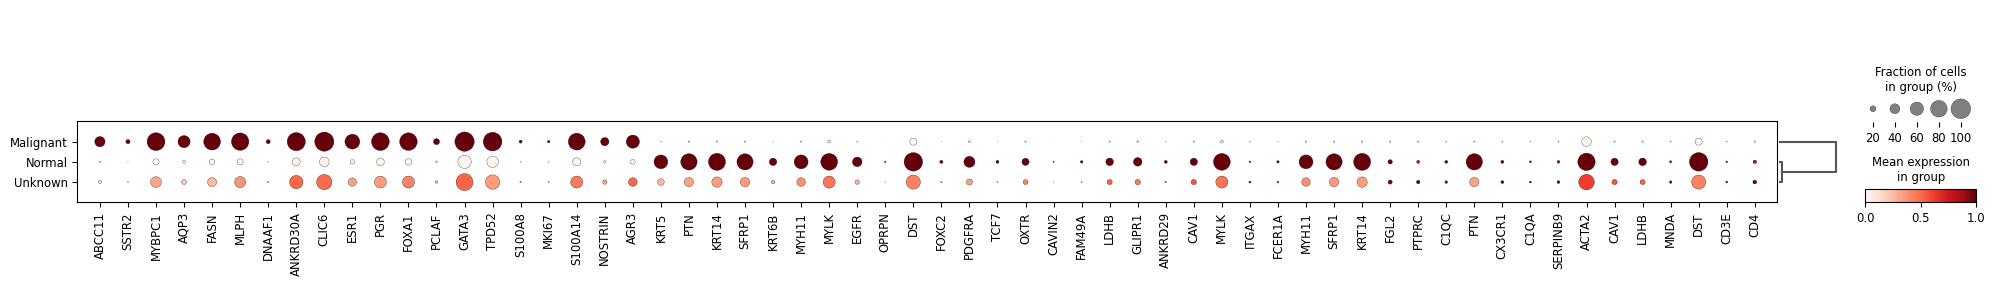

In [6]:
# Differential Gene Expression (DGE)
sc.tl.rank_genes_groups(
    epithelial_cells,
    groupby='cell_type_prediction',
    method='wilcoxon')

# Filtering parameters
logfc_cutoff = 0.58
pval_cutoff = 0.01
top_n = 20

def get_filtered_top_genes(adata, group, top_n, lfc_cut, pval_cut):
    df = sc.get.rank_genes_groups_df(adata, group=group)
    filtered = df[(df['logfoldchanges'] > lfc_cut) & (df['pvals'] < pval_cut)]
    return filtered.sort_values('logfoldchanges', ascending=False)["names"].head(top_n).tolist()

# Extract top filtered genes for each group
top_genes_malignant = get_filtered_top_genes(epithelial_cells, "Malignant", top_n, logfc_cutoff, pval_cutoff)
top_genes_normal = get_filtered_top_genes(epithelial_cells, "Normal", top_n, logfc_cutoff, pval_cutoff)
top_genes_unknown = get_filtered_top_genes(epithelial_cells, "Unknown", top_n, logfc_cutoff, pval_cutoff)

# Store top genes in a dictionary
top_genes_dict = {
    "Malignant": top_genes_malignant,
    "Normal": top_genes_normal,
    "Unknown": top_genes_unknown}

# Calculate signature scores for each group
for group, genes in top_genes_dict.items():
    if genes:  # run only if genes are available
        sc.tl.score_genes(epithelial_cells, gene_list=genes, score_name=f"{group}_signature_score")

# Maintain order: Malignant → Normal → Unknown
all_top_genes_ordered = top_genes_malignant + top_genes_normal + top_genes_unknown

# Dotplot visualization
sc.pl.dotplot(
    epithelial_cells,
    var_names=all_top_genes_ordered,
    groupby='cell_type_prediction',
    standard_scale='var',
    dendrogram=True,
    save='dotplot_top_genes.pdf')

## Signature Score Analysis  

To evaluate the relevance of the malignant, normal, and unknown molecular signatures across cell types, I constructed a **melted DataFrame** suitable for visualization with Seaborn.  
This allowed me to represent the distribution of the three signature scores (*Malignant*, *Unknown*, and *Normal*) across the predicted cell types.  

I used a combination of **boxplots** (to summarize the score distribution) and **stripplots** (to visualize individual data points) for a more detailed view.  
The average scores for each group were also computed to assess the discriminative power of the signatures.  

Interestingly, the *Unknown_signature_score* showed higher values in the **Normal** cell group, suggesting that this signature is **not sufficiently discriminative** for distinguishing between malignant and normal cells.  

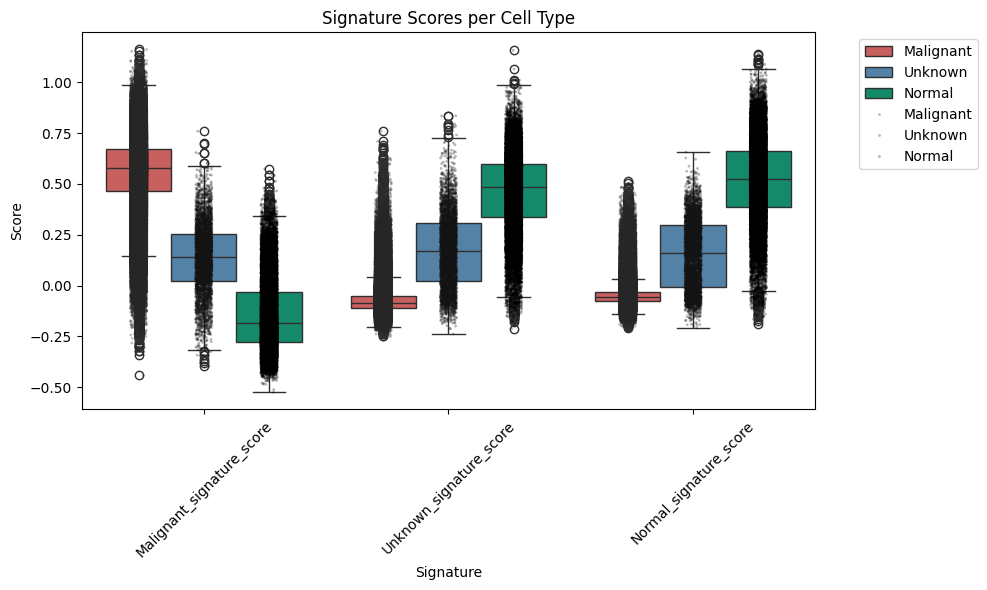

Malignant_signature_score  Unknown_signature_score  \
cell_type_prediction                                                       
Malignant                              0.558039                -0.072980   
Unknown                                0.134698                 0.172228   
Normal                                -0.144003                 0.461100   

                      Normal_signature_score  
cell_type_prediction                          
Malignant                          -0.047561  
Unknown                             0.155406  
Normal                              0.519084

In [7]:
# Data 
df = epithelial_cells.obs[['cell_type_prediction', 
                           'Malignant_signature_score', 
                           'Unknown_signature_score', 
                           'Normal_signature_score']].copy()

# Set the desired category order
desired_order = ['Malignant', 'Unknown', 'Normal']
df['cell_type_prediction'] = pd.Categorical(df['cell_type_prediction'], 
                                            categories=desired_order, ordered=True)

# Convert to long format for seaborn
df_melted = df.melt(id_vars='cell_type_prediction', 
                    var_name='Signature', 
                    value_name='Score')

# Custom color palette 
color_dict = {
    'Malignant': '#D94F4F', 
    'Normal': '#009E73',    
    'Unknown': '#4682B4'     }

# Boxplot with overlayed points 
plt.figure(figsize=(10, 6))

sns.boxplot(data=df_melted, 
            x='Signature', y='Score', 
            hue='cell_type_prediction', 
            palette=color_dict, 
            hue_order=desired_order)

sns.stripplot(data=df_melted, 
              x='Signature', y='Score', 
              hue='cell_type_prediction', 
              dodge=True, color='black', alpha=0.3, size=2, 
              hue_order=desired_order)

plt.title('Signature Scores per Cell Type')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure in the figures folder 
plt.savefig("figures/signature_scores_per_cell_type.png", dpi=300)  # high quality for thesis
plt.show()

# Check mean signature scores per cell type 
df.groupby('cell_type_prediction')[
    ['Malignant_signature_score', 'Unknown_signature_score', 'Normal_signature_score']].mean()

## Reclassification of Unknown Cells Using Signature Thresholds  

To refine the classification of cells initially labeled as **Unknown**, I analyzed their *Normal* and *Malignant* signature scores.  

1. **Subset selection**: only cells predicted as *Unknown* were considered.  
2. **Threshold estimation**:  
   - If the score distribution was **bimodal**, the threshold was set at the valley between the two peaks (based on KDE).  
   - If the distribution was **unimodal**, the threshold was defined at the 75th percentile.  
3. **Reclassification**:  
   - Cells with scores above the malignant threshold were reclassified as *Malignant*.  
   - Cells with scores below the normal threshold were reclassified as *Normal*.  
4. **Visualization**: KDE plots with thresholds were generated for both signatures, along with a combined plot for comparison.  
5. **Correlation analysis**: The relationship between *Normal* and *Malignant* scores was assessed using Pearson’s correlation.  

This approach allows a data-driven refinement of the ambiguous *Unknown* cell population, improving separation between normal-like and malignant-like epithelial cells.  

Normal_signature_score --> Bimodal: Estimated threshold = 0.125
Malignant_signature_score --> Unimodal: Threshold set at 75th percentile = 0.253


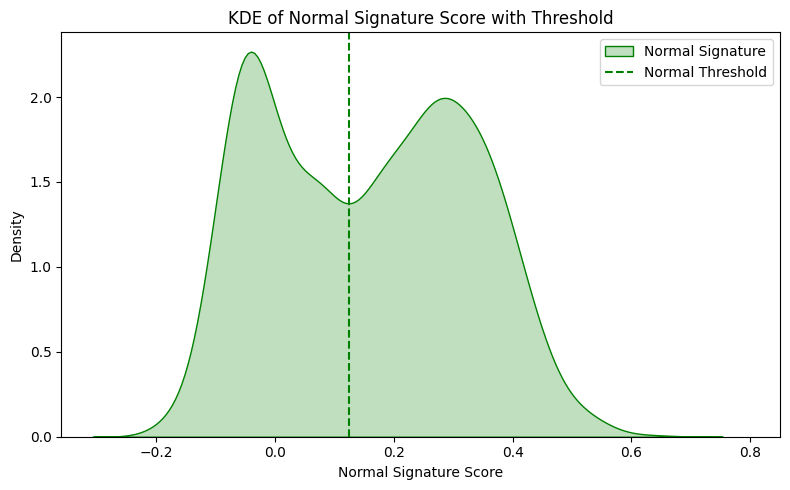

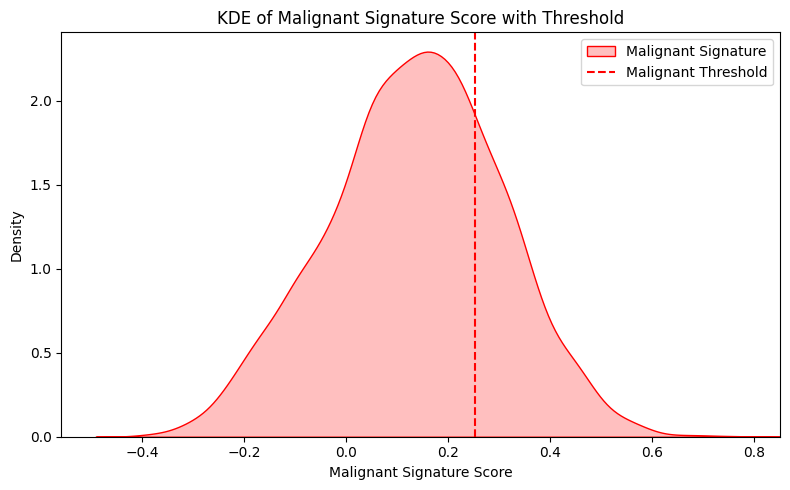

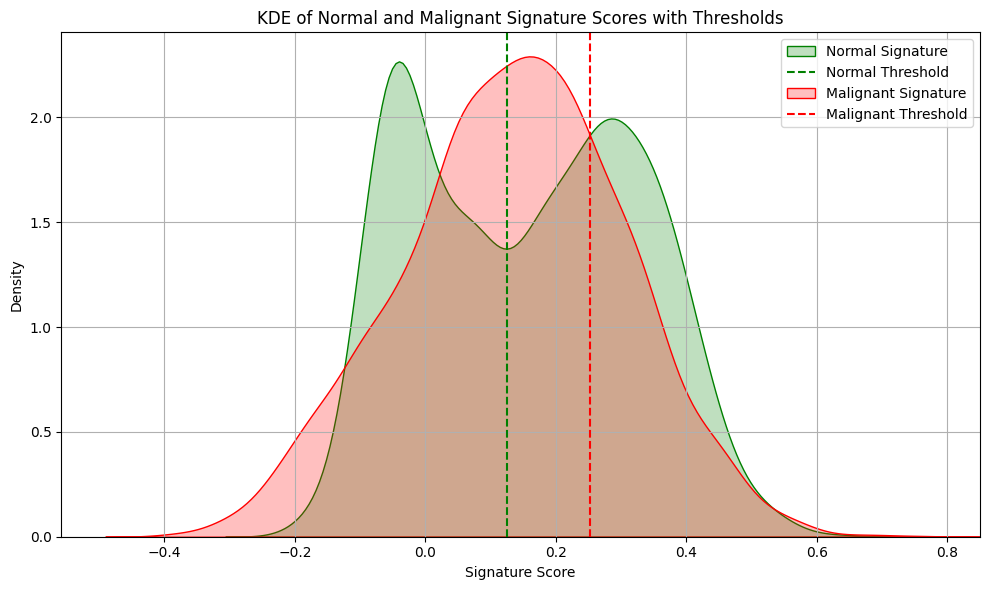


Correlation between Normal and Malignant signatures (epithelial Unknown cells):
                           Normal_signature_score  Malignant_signature_score
Normal_signature_score                    1.00000                    0.24854
Malignant_signature_score                 0.24854                    1.00000


In [7]:
# Select only Unknown cells
df_unknown = df[df['cell_type_prediction'] == 'Unknown'].copy()

# Updated function to find threshold and classify
def analyze_signature(df, column, direction='greater', percentile=0.75):
    scores = df[column].dropna().values
    
    # Compute KDE
    kde_plot = sns.kdeplot(scores, bw_adjust=1)
    x_vals, y_vals = kde_plot.get_lines()[0].get_data()
    plt.close()  # prevent plotting here
    
    # Find peaks
    peaks, _ = find_peaks(y_vals)
    
    if len(peaks) >= 2:
        # Bimodal: threshold between two main peaks
        peak1, peak2 = sorted(peaks[:2])
        valley_idx = np.argmin(y_vals[peak1:peak2])
        threshold = x_vals[peak1 + valley_idx]
        print(f"{column} --> Bimodal: Estimated threshold = {threshold:.3f}")
    else:
        # Unimodal: use percentile
        threshold = np.percentile(scores, percentile*100)
        print(f"{column} --> Unimodal: Threshold set at {percentile*100:.0f}th percentile = {threshold:.3f}")
    
    # Classification
    class_column = f"new_class_{column.split('_')[0].lower()}"
    if direction == 'greater':
        df[class_column] = df[column].apply(lambda x: 'Malignant' if x > threshold else 'Normal')
    else:
        df[class_column] = df[column].apply(lambda x: 'Malignant' if x < threshold else 'Normal')
    
    return df, threshold, class_column

# Apply the function to the two signatures
df_unknown, threshold_normal, class_col_normal = analyze_signature(
    df_unknown, 'Normal_signature_score', direction='less')
df_unknown, threshold_malignant, class_col_malignant = analyze_signature(
    df_unknown, 'Malignant_signature_score', direction='greater')

# KDE plot for Normal signature
plt.figure(figsize=(8, 5))
sns.kdeplot(df_unknown['Normal_signature_score'].dropna(), fill=True, color='green', label='Normal Signature')
plt.axvline(threshold_normal, color='green', linestyle='--', label='Normal Threshold')
plt.title('KDE of Normal Signature Score with Threshold')
plt.xlabel('Normal Signature Score')
plt.ylabel('Density')
plt.legend()
plt.xlim(right=0.85)  # set x-axis maximum
plt.tight_layout()
plt.savefig("figures/KDE_Normal_signature.png", dpi=300) 
plt.show()

# KDE plot for Malignant signature
plt.figure(figsize=(8, 5))
sns.kdeplot(df_unknown['Malignant_signature_score'].dropna(), fill=True, color='red', label='Malignant Signature')
plt.axvline(threshold_malignant, color='red', linestyle='--', label='Malignant Threshold')
plt.title('KDE of Malignant Signature Score with Threshold')
plt.xlabel('Malignant Signature Score')
plt.ylabel('Density')
plt.legend()
plt.xlim(right=0.85)  # set x-axis maximum
plt.tight_layout()
plt.savefig("figures/KDE_Malignant_signature.png", dpi=300)  
plt.show()

# Combined KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df_unknown['Normal_signature_score'].dropna(), fill=True, color='green', label='Normal Signature')
plt.axvline(threshold_normal, color='green', linestyle='--', label='Normal Threshold')
sns.kdeplot(df_unknown['Malignant_signature_score'].dropna(), fill=True, color='red', label='Malignant Signature')
plt.axvline(threshold_malignant, color='red', linestyle='--', label='Malignant Threshold')
plt.title('KDE of Normal and Malignant Signature Scores with Thresholds')
plt.xlabel('Signature Score')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.xlim(right=0.85)  # set x-axis maximum
plt.tight_layout()
plt.savefig("figures/KDE_Normal_and_Malignant_signatures.png", dpi=300) 
plt.show()

# Correlation between the two signature scores
correlation = df_unknown[['Normal_signature_score', 'Malignant_signature_score']].corr()
print("\nCorrelation between Normal and Malignant signatures (epithelial Unknown cells):")
print(correlation)

## Validation of Unknown Cell Reclassification  

To evaluate the consistency between the two reclassification approaches (based on Normal vs. Malignant signature thresholds), I generated:  

- A **contingency table** (crosstab) to compare the class assignments.  
- A **scatterplot** of Normal vs. Malignant signature scores, colored by the new classification.  
- An **agreement metric** reporting the percentage of cells assigned to the same class by both methods.

The low positive correlation between Normal and Malignant signature scores indicates that Unknown cells are heterogeneous and may include multiple subpopulations.

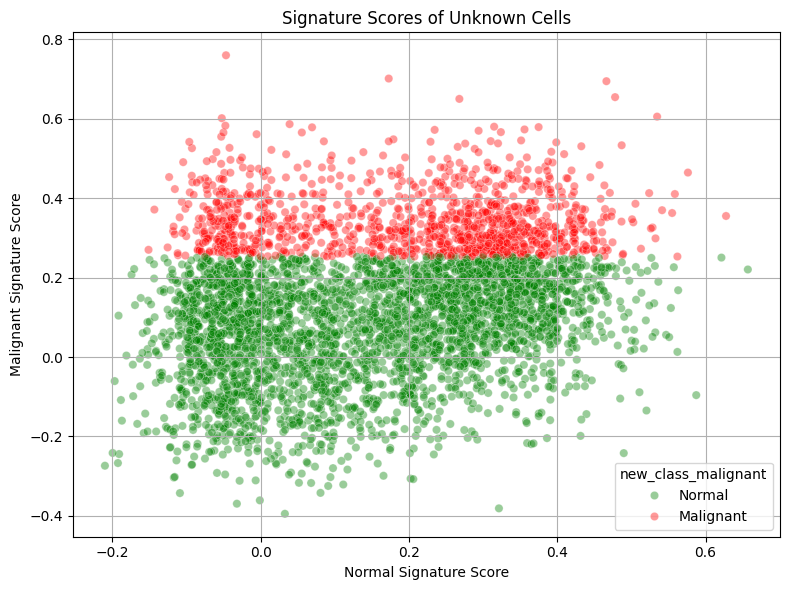

Agreement between the two classifications: 2032/4311 (47.14%)


In [9]:
# Concordance between reclassification approaches

# Contingency table
pd.crosstab(df_unknown['new_class_normal'], df_unknown['new_class_malignant'])

# Scatterplot of signature scores
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_unknown,
    x='Normal_signature_score',
    y='Malignant_signature_score',
    hue='new_class_malignant',  # or 'new_class_normal'
    alpha=0.4,
    palette={'Normal': 'green', 'Malignant': 'red'})
plt.title('Signature Scores of Unknown Cells')
plt.xlabel('Normal Signature Score')
plt.ylabel('Malignant Signature Score')
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/scatter_new_class_malignant.png', format='png')
plt.show()

# Agreement check
match = (df_unknown['new_class_normal'] == df_unknown['new_class_malignant']).sum()
total = len(df_unknown)
print(f"Agreement between the two classifications: {match}/{total} ({100 * match/total:.2f}%)")

## Differential Gene Expression of Unknown Cells  

To identify candidate marker genes for the cells labeled as **Unknown**, I performed differential gene expression (DGE) analysis comparing:  

1. **Unknown vs Malignant**  
2. **Unknown vs Normal**  

Genes with adjusted *p*-value < 0.01 and log fold change > 0.58 were considered significant.  
Finally, I extracted the genes that were consistently overexpressed in both comparisons as potential **marker genes** for the Unknown cell population.

In [9]:
# Define comparisons
comparisons = {'UM': 'Malignant', 'UN': 'Normal'}
dge_results = {}

for label, ref in comparisons.items():
    sc.tl.rank_genes_groups(
        epithelial_cells,
        groupby='cell_type_prediction',
        groups=['Unknown'],
        reference=ref,
        method='wilcoxon')
    
    # Save results in DataFrame
    df = sc.get.rank_genes_groups_df(epithelial_cells, group='Unknown')
    
    # Filter significant genes (adj p-value < 0.01, logFC > 0.58)
    df_sig = df[(df['pvals_adj'] < 0.01) & (df['logfoldchanges'] > 0.58)]
    dge_results[label] = df_sig.rename(columns={'logfoldchanges': f'logFC_{label}'})

# Merge the results to get genes significant in both comparisons
common_genes = pd.merge(
    dge_results['UM'][['names', 'logFC_UM']],
    dge_results['UN'][['names', 'logFC_UN']],
    on='names')

print(f"Candidate marker genes for Unknown cells (overexpressed in both comparisons): {len(common_genes)}")
display(common_genes.sort_values(by='logFC_UM', key=abs, ascending=False))

Candidate marker genes for Unknown cells (overexpressed in both comparisons): 7


names  logFC_UM  logFC_UN
0    TCIM  1.625417  1.584808
1  CCDC80  1.593636  1.047891
6     DPT  1.501426  1.858803
5    GJB2  1.166832  1.215615
4   SFRP4  1.003335  2.073271
2  CXCL12  0.985716  0.888535
3     LUM  0.898820  1.000946

## Expression Analysis of Selected Genes Across Cell Types  

To investigate the cell type-specific expression of selected genes (**TCIM, CCDC80, DPT, GJB2, SFRP4, CXCL12, LUM**), I merged the cell type annotations (`classification_df`) with the spatial transcriptomics dataset (`xenium`).  

For each gene, the **average expression per cell type** was calculated, highlighting the cell types with the highest expression.  
A **dotplot** was generated to visualize both the average expression (color intensity) and the percentage of cells expressing each gene (dot size) across the major cell types (`level1`).  

TCIM    CCDC80       DPT      GJB2     SFRP4    CXCL12  \
cell_type                                                                       
Connective_tissue  0.301902  4.950244  0.681765  1.577111  5.302217  5.557476   
Epithelial         0.241657  0.226388  0.038155  0.072800  0.181160  0.445589   
Immune             0.114595  1.702884  0.311144  0.402922  1.839530  2.280010   
Vascular           1.465394  1.324619  0.140365  0.315048  0.924253  2.163663   

                         LUM  TCIM_frac  CCDC80_frac  DPT_frac  GJB2_frac  \
cell_type                                                                   
Connective_tissue  14.961612   0.192106     0.871652  0.377456   0.540310   
Epithelial          0.828628   0.099895     0.133214  0.031991   0.052391   
Immune              4.771965   0.087915     0.571433  0.213350   0.219625   
Vascular            4.019607   0.519538     0.538380  0.107632   0.177828   

                   SFRP4_frac  CXCL12_frac  LUM_frac  
cell_type                                             
Connective_tissue    0.721993     0.852244  0.978424  
Epithelial           0.097046     0.247630  0.281551  
Immune               0.489127     0.659551  0.768712  
Vascular             0.352266     0.637726  0.710684

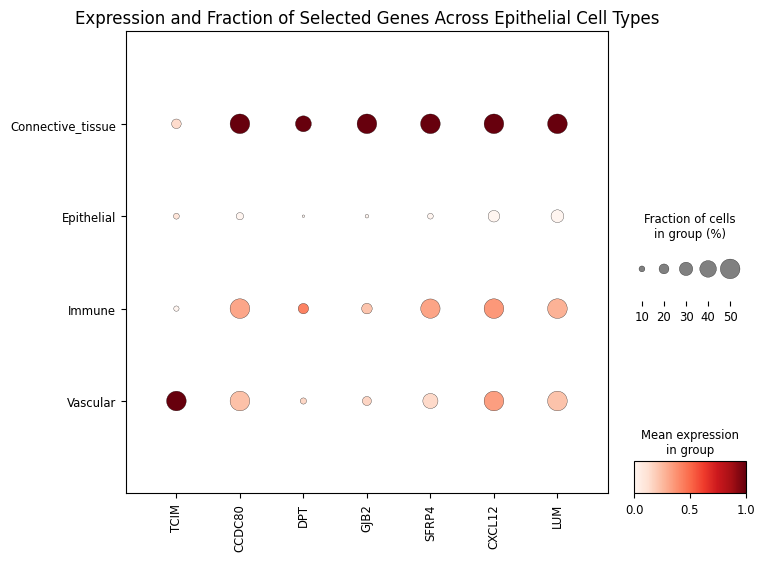

In [10]:
adata = xenium.tables['table']

# Merge classification info
adata.obs = adata.obs.merge(
    classification_df[['cell_id', 'level1']],
    on='cell_id',
    how='left')

# Genes of interest
genes = ['TCIM', 'CCDC80', 'DPT', 'GJB2', 'SFRP4', 'CXCL12', 'LUM']

# Extract expression data
adata_selected = adata[:, genes]

# Create DataFrame with expression and cell type
df = pd.DataFrame(adata_selected.X.toarray(), columns=genes, index=adata.obs.index)
df['cell_type'] = adata.obs['level1'].values

# Compute mean expression per gene for each cell type
mean_expression = df.groupby('cell_type')[genes].mean()

# Compute fraction of cells expressing each gene (>0) per cell type
fraction_expressing = df.groupby('cell_type')[genes].apply(lambda x: (x>0).sum()/x.shape[0])

# Combine mean expression and fraction into one summary table
summary_df = pd.concat([mean_expression, fraction_expressing.add_suffix('_frac')], axis=1)
display(summary_df.sort_index())

# Dotplot visualization
sc.pl.dotplot(
    adata,
    var_names=genes,
    groupby='level1',
    standard_scale='var',  
    dot_max=0.5,          
    figsize=(8, 6),
    dendrogram=False,
    show=True,        
    title='Expression and Fraction of Selected Genes Across Epithelial Cell Types',
    save="_dotplot.png")

## GMM Clustering of Epithelial Cells Using Signature Genes  

The epithelial cell dataset was subset to include only the top marker genes identified in the Normal, Malignant, and Unknown populations. This subset was used to investigate whether these signature genes can separate epithelial cells into biologically meaningful subpopulations.

**Gaussian Mixture Model (GMM) Clustering**: 
- A GMM with two components (n_components=2) was applied to the expression matrix of the signature genes.
- Each cell was assigned a cluster label (GMM_cluster) corresponding to one of the two inferred subpopulations.

**UMAP Embedding**:
- UMAP was computed on the full epithelial cell dataset to capture the global structure of the cells in a two-dimensional space.
- Two UMAP plots were generated side by side: one colored by the GMM clusters and the other by the original cell type predictions (Normal, Malignant, Unknown). This allows comparison between the computational clustering and the predicted annotations.

**Cross-tabulation and Barplot Analysis**:
- A cross-tabulation was performed to assess the overlap between GMM clusters and the original cell type predictions.
- Unknown cells were classified according to their GMM cluster membership, providing insight into which cluster each ambiguous cell likely belongs to.
- The number of Unknown cells assigned to each GMM cluster was visualized using a barplot, with colors corresponding to Normal (blue) or Malignant (red) assignments.

**Interpretation**: 
- This analysis allows validation of whether the selected signature genes are sufficient to distinguish epithelial subpopulations.
- The approach also provides a principled way to assign previously ambiguous (Unknown) cells to a likely cell type based on their transcriptional profile.

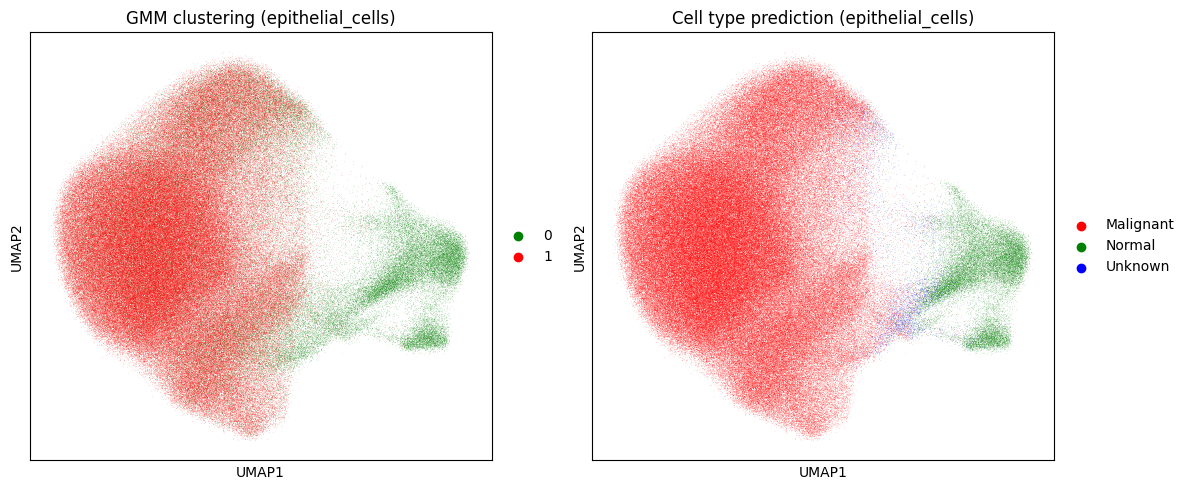

cell_type_prediction  Malignant  Normal  Unknown
GMM_cluster                                     
0                         50314   25029     3317
1                        268822     216      994


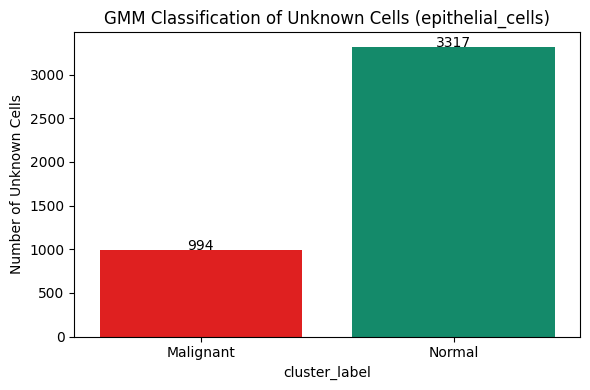

In [14]:
# Dataset
adata = epithelial_cells
dataset_name = 'epithelial_cells'

# Combine top marker genes from Normal, Malignant, and Unknown groups
top_all = list(set(top_genes_normal + top_genes_malignant + top_genes_unknown))
genes_present = [gene for gene in top_all if gene in adata.var_names]

# Subset the expression matrix to include only the signature genes
epithelial_cells_sig = adata[:, genes_present].copy()

# Apply Gaussian Mixture Model (GMM) clustering on the signature genes
X = epithelial_cells_sig.X.toarray() if not isinstance(epithelial_cells_sig.X, np.ndarray) else epithelial_cells_sig.X
gmm = GaussianMixture(n_components=2, random_state=42)
labels = gmm.fit_predict(X)
adata.obs['GMM_cluster'] = labels.astype(str)

# Compute UMAP embeddings for the full epithelial dataset
sc.pp.neighbors(adata)
sc.tl.umap(adata)

# Plot UMAP side-by-side: GMM clusters vs original cell type predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(
    adata,
    color='GMM_cluster',
    palette=['green', 'red'],
    title=f'GMM clustering ({dataset_name})',
    ax=axes[0],
    show=False)

sc.pl.umap(
    adata,
    color='cell_type_prediction',
    palette={'Normal': 'green', 'Malignant': 'red', 'Unknown': 'blue'},
    title=f'Cell type prediction ({dataset_name})',
    ax=axes[1],
    show=False)

plt.tight_layout()
os.makedirs("figures", exist_ok=True)
fig.savefig(f'figures/umap_gmm_vs_celltype_{dataset_name}.png', dpi=300)
plt.show()

# Cross-tabulation to assess overlap between GMM clusters and cell type predictions
print(pd.crosstab(adata.obs['GMM_cluster'], adata.obs['cell_type_prediction']))

# Barplot showing classification of Unknown cells according to GMM clusters
unknown_cells = adata[adata.obs['cell_type_prediction'] == 'Unknown']
cluster_label_map = { '0': 'Normal', '1': 'Malignant' }
df_plot = unknown_cells.obs[['GMM_cluster']].copy()
df_plot['cluster_label'] = df_plot['GMM_cluster'].map(cluster_label_map)

desired_order = ['Malignant', 'Normal']
desired_palette = {'Malignant': 'red', 'Normal': '#009E73'}

plt.figure(figsize=(6,4))
ax = sns.countplot(
    data=df_plot, 
    x='cluster_label',
    order=desired_order, 
    palette=desired_palette)

plt.title(f'GMM Classification of Unknown Cells ({dataset_name})')
plt.ylabel('Number of Unknown Cells')

# Add value labels above bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1,
            int(height), ha="center", fontsize=10)

plt.tight_layout()
plt.savefig(f'figures/barplot_unknown_gmm_classification_{dataset_name}.png', dpi=300)
plt.show()

## Cluster-specific UMAPs  

To inspect the spatial distribution of cells in more detail, separate UMAP plots were generated for each GMM cluster and each predicted cell type.  
This allows visual assessment of how well the signature genes separate subpopulations and how Unknown cells are distributed across clusters.

▶️ Cluster 0 - n_cells: 78660


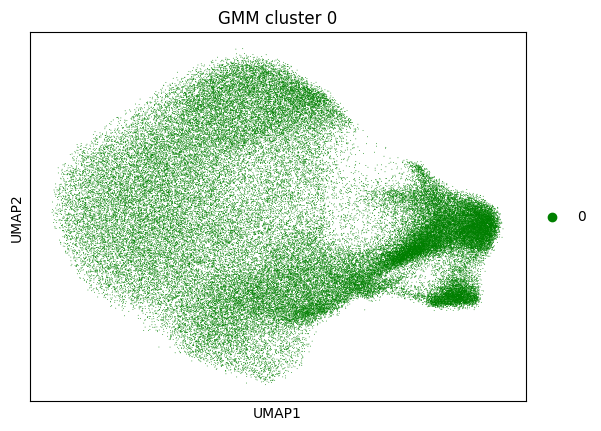

▶️ Cluster 1 - n_cells: 270032


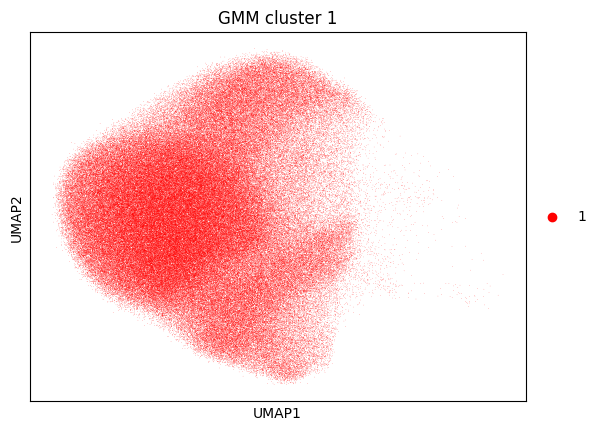

▶️ Cell type: Malignant - n_cells: 319136


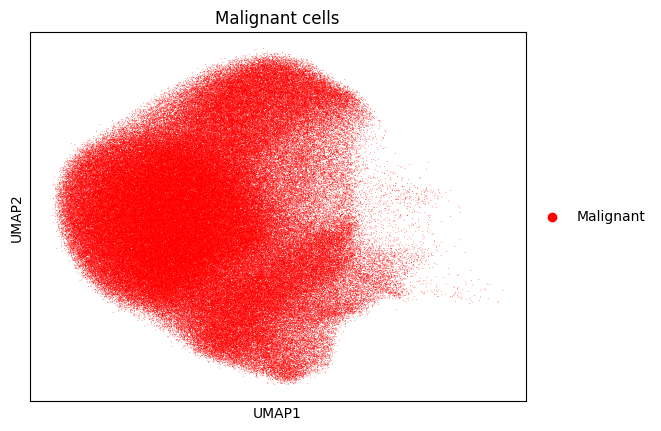

▶️ Cell type: Normal - n_cells: 25245


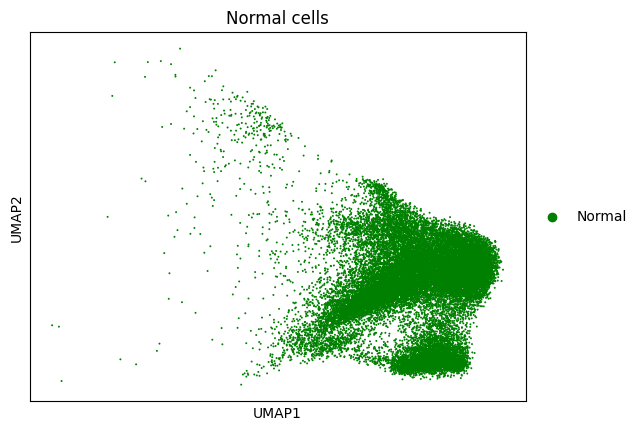

▶️ Cell type: Unknown - n_cells: 4311


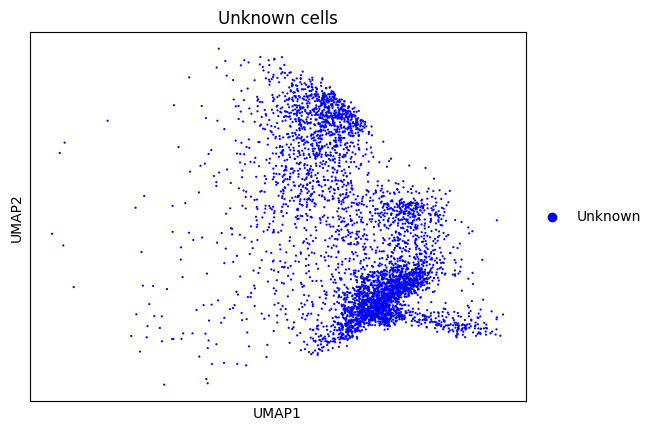

In [15]:
# Separate plots for each GMM cluster
for i, color in zip(['0', '1'], ['green', 'red']):
    subset = adata[adata.obs['GMM_cluster'].astype(str) == i]
    print(f"▶️ Cluster {i} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        sc.pl.umap(subset, color='GMM_cluster', title=f'GMM cluster {i}',
                   palette=[color], show=True)

# All cell types in a single loop with custom point sizes
cell_types = ['Malignant', 'Normal', 'Unknown']
colors = ['red', 'green', 'blue']

for ct, color in zip(cell_types, colors):
    subset = adata[adata.obs['cell_type_prediction'].astype(str) == ct]
    print(f"▶️ Cell type: {ct} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        # Set specific point size for each cell type
        if ct == 'Malignant':
            point_size = 1
        elif ct == 'Unknown':
            point_size = 10
        else:  # Normal
            point_size = 8

        sc.pl.umap(subset,
                   color='cell_type_prediction',
                   title=f'{ct} cells',
                   palette=[color],
                   size=point_size,
                   show=True)

## Function: Plot GMM Clusters Highlighting Unknown Cells

Define a helper function to visualize GMM clusters with Unknown cells highlighted.
- Left panel: GMM clustering of all cells, highlighting Unknown cells.
- Right panel: Only Unknown cells are shown in blue over the full dataset.

In [16]:
# FUNCTION to plot two side-by-side UMAPs:
# Left: GMM clustering with Unknown cells highlighted
# Right: Only Unknown cells highlighted in blue over the background of all cells

def plot_gmm_vs_unknown_highlight(
    adata,
    feature_key: str,
    cluster_key: str = 'GMM_cluster',
    title_left: str = 'GMM clustering of Unknown cells (highlighted)',
    title_right: str = 'Cell Type Prediction (highlight Unknown)',
    save_path: str = None):
   
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Masks for known and unknown cells
    mask_known = adata.obs['cell_type_prediction'].isin(['Normal', 'Malignant'])
    mask_unknown = adata.obs['cell_type_prediction'] == 'Unknown'

    # --- LEFT PANEL: GMM clustering with Unknown highlighted ---
    sc.pl.umap(
        adata[mask_known],
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray'},
        size=10,
        alpha=0.3,
        ax=axes[0],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color=cluster_key,
        palette=['green', 'red'],
        size=10,
        alpha=0.5,
        ax=axes[0],
        show=False,
        legend_loc='right')
    axes[0].set_title(title_left)
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='GMM cluster')

    # --- RIGHT PANEL: Highlight Unknown cells in red ---
    sc.pl.umap(
        adata,
        color='cell_type_prediction',
        palette={'Normal': 'lightgray', 'Malignant': 'lightgray', 'Unknown': 'lightgray'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False,
        legend_loc=None)
    sc.pl.umap(
        adata[mask_unknown],
        color='cell_type_prediction',
        palette={'Unknown': 'blue'},
        size=10,
        alpha=0.5,
        ax=axes[1],
        show=False)
    axes[1].set_title(title_right)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()

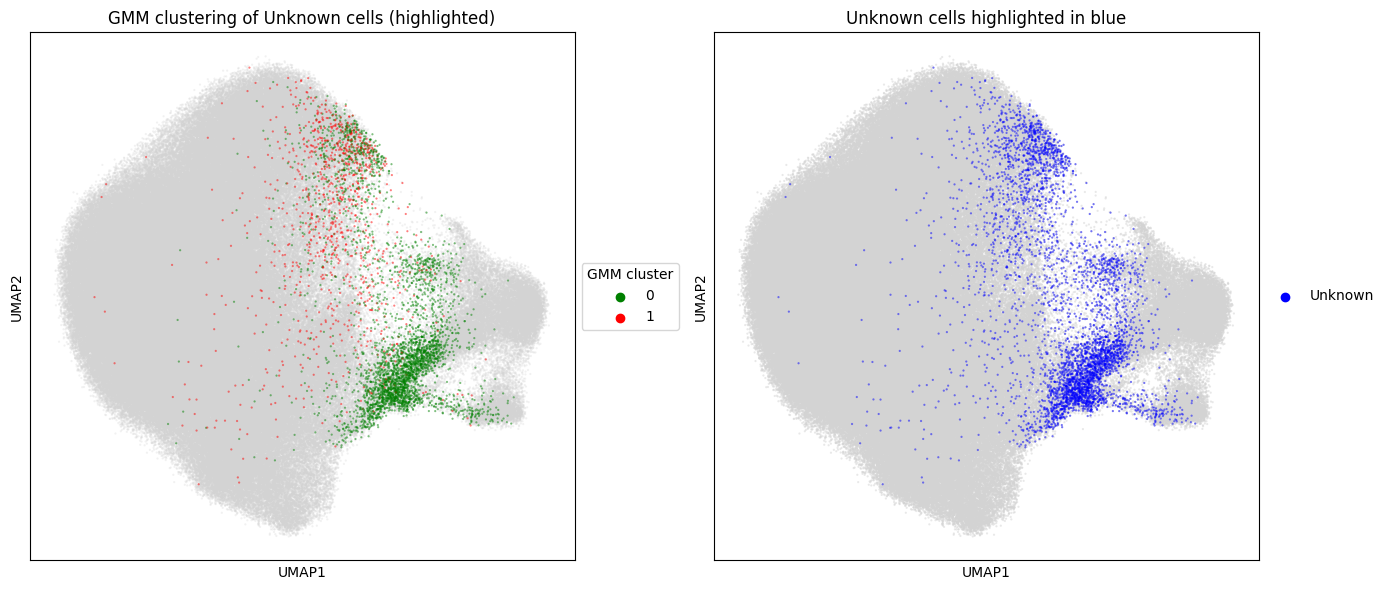

In [17]:
# Define a dynamic path using dataset_name
save_path = f'figures/umap_gmm_unknown_highlighted_{dataset_name}.png'

# Call the function with dynamic saving
plot_gmm_vs_unknown_highlight(
    adata=adata,
    feature_key='cell_type_prediction',
    cluster_key='GMM_cluster',
    title_left='GMM clustering of Unknown cells (highlighted)',
    title_right='Unknown cells highlighted in blue',
    save_path=save_path)

## Downsampled Epithelial Cell Dataset

Prepare a downsampled dataset for computational efficiency:
- Filter Normal, Malignant, and Unknown cells.
- Randomly downsample 25k Normal and 25k Malignant cells.
- Combine the downsampled Normal and Malignant cells with all 4,311 Unknown cells.
- Subset the dataset to include only the signature genes and apply normalization and log-transformation to the expression data.

In [18]:
# DOWNSAMPLED DATASET

# Filter Normal, Malignant, and Unknown cells
mask_nmu = epithelial_cells.obs['cell_type_prediction'].isin(['Normal', 'Malignant', 'Unknown'])
adata_nmu = epithelial_cells[mask_nmu].copy()

# Extract groups separately
normal_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Normal']
malignant_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Malignant']
unknown_cells = adata_nmu[adata_nmu.obs['cell_type_prediction'] == 'Unknown']

# Downsampling: 25k Normal + 25k Malignant
normal_sample = normal_cells[np.random.choice(normal_cells.shape[0], 25000, replace=False)].copy()
malignant_sample = malignant_cells[np.random.choice(malignant_cells.shape[0], 25000, replace=False)].copy()

# Combine samples with all Unknown cells
adata_down = normal_sample.concatenate(malignant_sample, unknown_cells)

# Select only the present signature genes
top_all = list(set(top_genes_normal + top_genes_malignant))
genes_present = [gene for gene in top_all if gene in adata_down.var_names]
adata_down_sig = adata_down[:, genes_present].copy()

# Preprocess signature genes
sc.pp.normalize_total(adata_down_sig)
sc.pp.log1p(adata_down_sig)

# Apply GMM clustering on the signature genes
X = adata_down_sig.X.toarray() if not isinstance(adata_down_sig.X, np.ndarray) else adata_down_sig.X
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X)

# Add GMM cluster labels to the downsampled dataset
adata_down.obs['GMM_cluster'] = gmm_labels.astype(str)

## UMAP of Downsampled Dataset

Compute UMAP on the downsampled signature genes to visualize:
- Left: GMM clustering (k=2)
- Right: Original cell type prediction

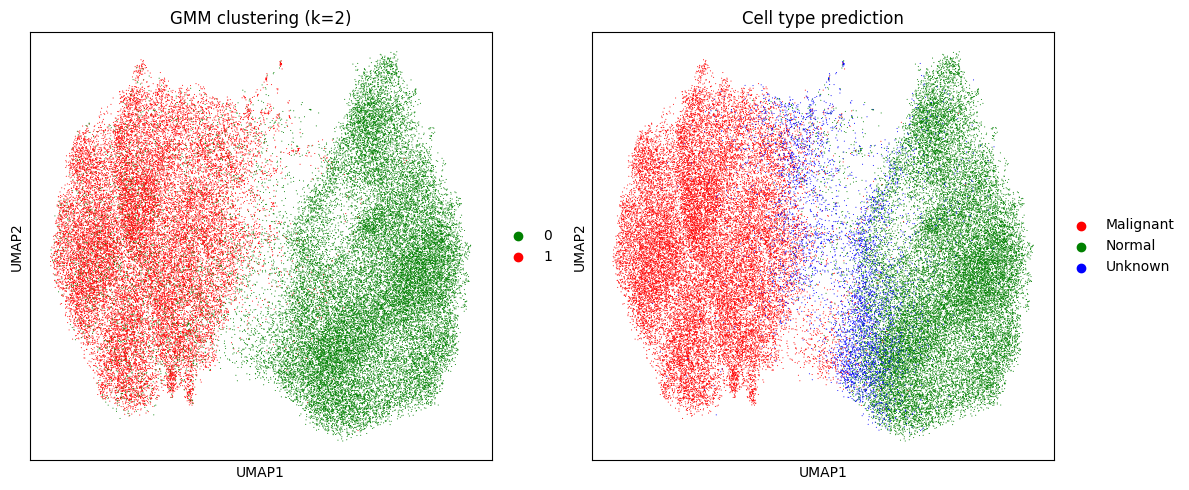

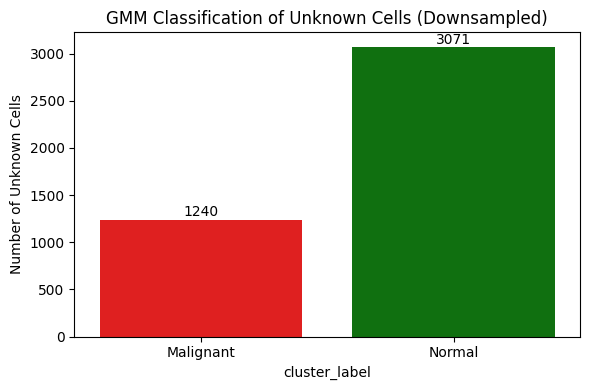

cell_type_prediction  Malignant  Normal  Unknown
GMM_cluster                                     
0                          2900   24729     3071
1                         22100     271     1240


In [19]:
# Compute UMAP embeddings for visualization (using only the signature genes)
sc.pp.neighbors(adata_down_sig)  
sc.tl.umap(adata_down_sig)       

# Transfer the UMAP embedding to the downsampled full dataset
adata_down.obsm['X_umap'] = adata_down_sig.obsm['X_umap']

# Plot side-by-side UMAPs: GMM clusters vs original cell type predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: GMM clustering (2 clusters) ---
sc.pl.umap(
    adata_down, 
    color='GMM_cluster', 
    palette=['green', 'red'], 
    ax=axes[0], 
    show=False, 
    title='GMM clustering (k=2)')

# --- Right: Original cell type annotations ---
sc.pl.umap(
    adata_down, 
    color='cell_type_prediction', 
    palette={'Normal': 'green', 'Malignant': 'red', 'Unknown': 'blue'},
    ax=axes[1], 
    show=False, 
    title='Cell type prediction')

plt.tight_layout()
fig.savefig('figures/umap_downsampled_gmm_plus_unknown.png', dpi=300)
plt.show()

# Barplot: GMM-based classification of Unknown cells
unknown_cells = adata_down[adata_down.obs['cell_type_prediction'] == 'Unknown']
df_plot = unknown_cells.obs[['GMM_cluster']].copy()

# Map GMM clusters to likely cell types based on cross-tabulation
df_plot['cluster_label'] = df_plot['GMM_cluster'].map({'0': 'Normal', '1': 'Malignant'})

plt.figure(figsize=(6,4))
ax = sns.countplot(
    data=df_plot,
    x='cluster_label',
    order=['Malignant', 'Normal'],
    palette={'Malignant': 'red', 'Normal': 'green'})
plt.title('GMM Classification of Unknown Cells (Downsampled)')
plt.ylabel('Number of Unknown Cells')

# Add integer labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 1,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=10)

plt.tight_layout()
plt.savefig('figures/barplot_unknown_gmm_downsampled.png', dpi=300)
plt.show()

# Contingency table: GMM clusters vs original cell type predictions
# This helps verify the mapping of GMM clusters to Normal/Malignant labels
print(pd.crosstab(adata_down.obs['GMM_cluster'], adata_down.obs['cell_type_prediction']))

## Cluster-specific UMAPs

Generate separate UMAP plots for each:
- GMM cluster
- Predicted cell type

▶️ Cluster 0 - n_cells: 30700


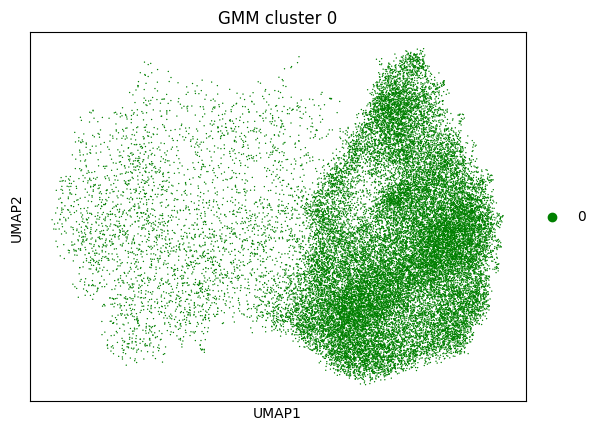

▶️ Cluster 1 - n_cells: 23611


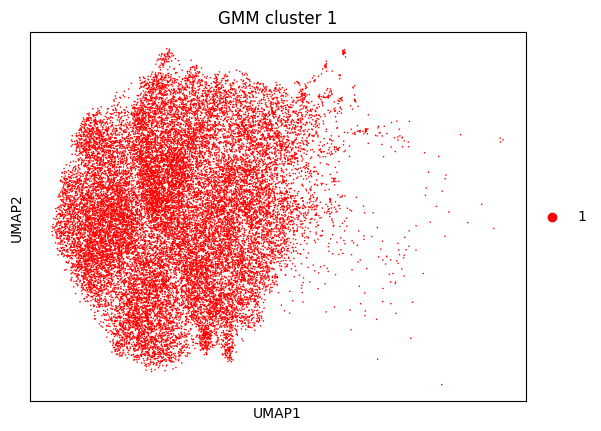

▶️ Cell type: Malignant - n_cells: 25000


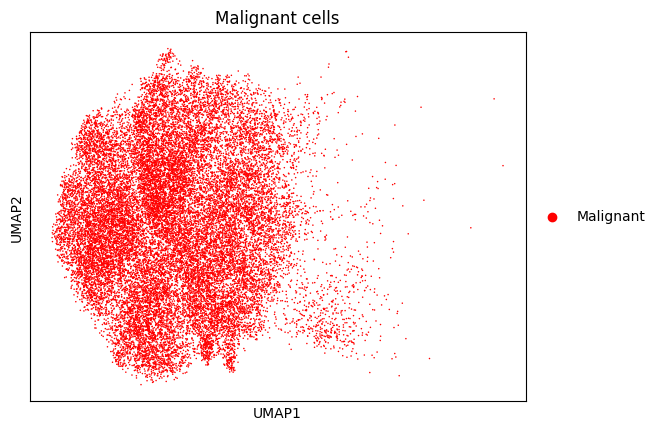

▶️ Cell type: Normal - n_cells: 25000


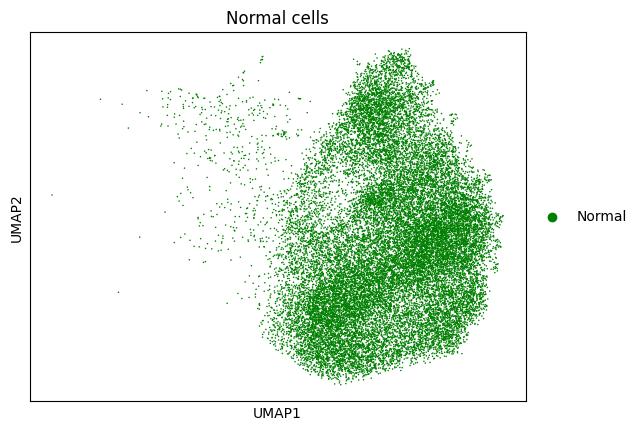

▶️ Cell type: Unknown - n_cells: 4311


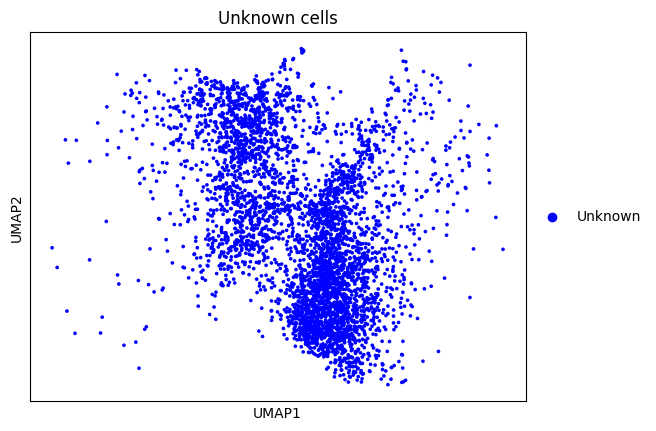

In [20]:
# Separate UMAP plots for each GMM cluster 
for i, color in zip(['0', '1'], ['green', 'red']):
    subset = adata_down[adata_down.obs['GMM_cluster'].astype(str) == i]
    print(f"▶️ Cluster {i} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        # Plot UMAP for the subset corresponding to this GMM cluster
        sc.pl.umap(
            subset, 
            color='GMM_cluster', 
            title=f'GMM cluster {i}',
            palette=[color], 
            show=True)

# Separate UMAP plots for each original cell type 
for ct, color in zip(['Malignant', 'Normal', 'Unknown'], ['red', 'green', 'blue']):
    subset = adata_down[adata_down.obs['cell_type_prediction'].astype(str) == ct]
    print(f"▶️ Cell type: {ct} - n_cells: {subset.n_obs}")
    if subset.n_obs > 0:
        # Plot UMAP for the subset corresponding to this cell type
        sc.pl.umap(
            subset,
            color='cell_type_prediction',
            title=f'{ct} cells',
            palette=[color],
            show=True)

## Highlight Unknown Cells on GMM UMAP

Use the `plot_gmm_vs_unknown_highlight` function to highlight Unknown cells in blue while showing the overall GMM clustering.

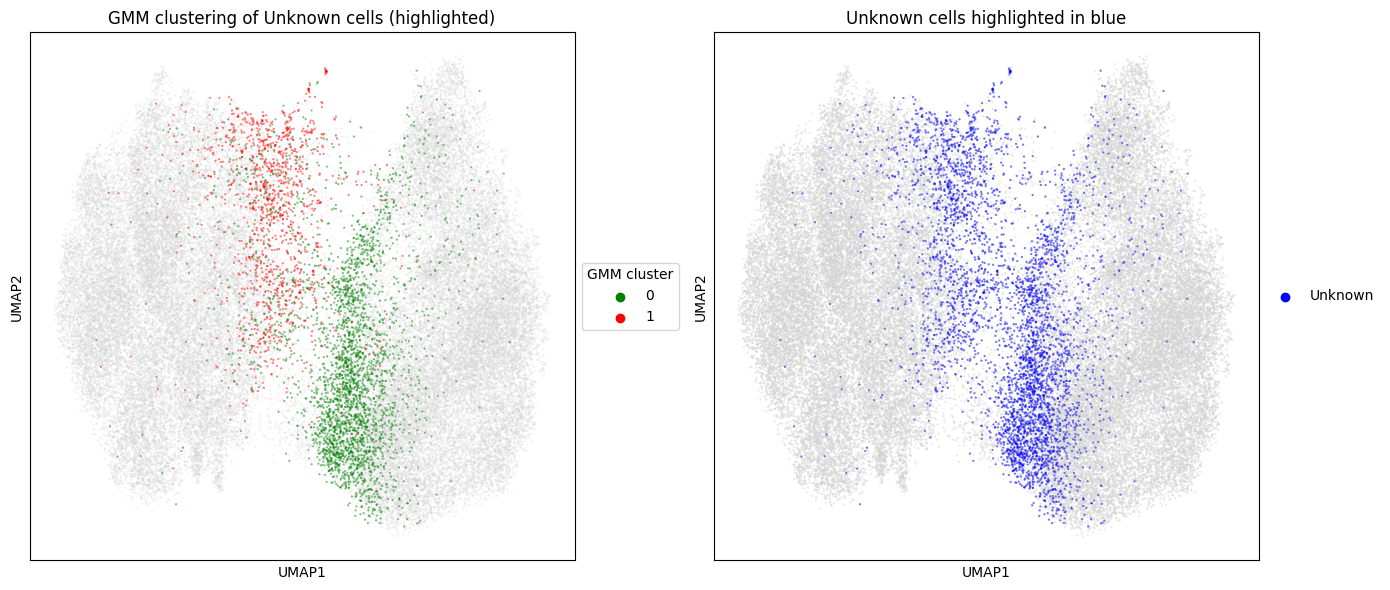

In [21]:
plot_gmm_vs_unknown_highlight(
    adata=adata_down,
    feature_key='cell_type_prediction',
    cluster_key='GMM_cluster',
    title_left='GMM clustering of Unknown cells (highlighted)',
    title_right='Unknown cells highlighted in blue',
    save_path='figures/umap_gmm_unknown_highlighted.png')